# Neural nets for Kriegeskorte images

**MAKE SURE TO CONNECT TO GPU RUNTIME IN NOTEBOOK SETTINGS**

Olivia Yoo

Neuro 140

April 13, 2023

In [1]:
%matplotlib inline
import os
import random
import copy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas.core.common import flatten
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader

import torch
from torch import nn, optim

import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
# HELPER FUNCTION
def digitize_rdm(rdm_raw, n_bins = 10): 
    """Digitize an input matrix to n bins (10 bins by default)
    rdm_raw: a square matrix 
    """
    # compute the bins 
    
    rdm_bins = [np.percentile(np.ravel(rdm_raw), 100/n_bins * i) for i in range(n_bins)]
    # Compute the vectorized digitized value 
    rdm_vec_digitized = np.digitize(np.ravel(rdm_raw), bins = rdm_bins) * (100 // n_bins) 
    
    # Reshape to matrix
    rdm_digitized = np.reshape(rdm_vec_digitized, np.shape(rdm_raw)) 
    
    # Force symmetry in the plot
    rdm_digitized = (rdm_digitized + rdm_digitized.T) / 2
    
    return rdm_digitized

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 128

# 1: Load in images.

In [4]:
# mount Drive to notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# set up file paths for image data
CUR_PATH = '/content/drive/MyDrive/Semester 8/Neuro 140/data'
IMAGE_PATH = CUR_PATH + '/images.npy'
LABEL_PATH = CUR_PATH + '/image_labels.npy'

In [6]:
# load in images and check shape
input_images = np.load(IMAGE_PATH, allow_pickle=True)
input_labels = np.load(LABEL_PATH)
class_names = ['artificial inanimate',
               'human body part',
               'human face',
               'natural inanimate',
               'nonhuman body part',
               'nonhuman face'] # in order of the labels
input_images.shape, input_labels.shape

((92, 1), (92,))

## 1.1: Check images.
There are 92 images, each 175 by 175 3 channel RGB. These images are in the specific ordering used to construct the RDMs.

In [ ]:
input_images[0,0].shape

(175, 175, 3)

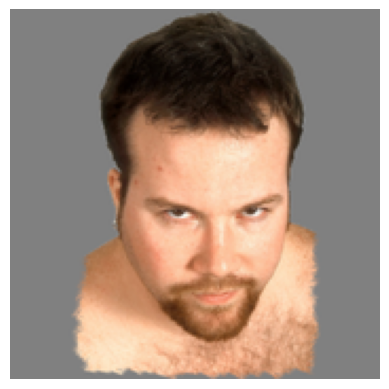

In [ ]:
# sample plotting for an image
plt.imshow(input_images[0,0])
plt.grid(None)
plt.axis('off');

## 1.2: Create PyTorch dataloader.

In [7]:
# transforms to process the images
basic_transforms = A.Compose(
    [
        A.Resize(224, 224),
        A.HorizontalFlip(),
        A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
)

mod_transforms = A.Compose(
    [
        A.RandomResizedCrop(224, 224),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
        ToTensorV2()
    ]
)

In [8]:
# create Dataset class
class ImageDataset(Dataset):
    def __init__ (self, images, transform=False):
        self.images = images
        self.transform = transform 

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx, 0]
        label = input_labels[idx]

        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image 

In [9]:
input_dataset = ImageDataset(input_images, basic_transforms)
input_loader = DataLoader(input_dataset, batch_size=BATCH_SIZE)

In [10]:
mod_dataset = ImageDataset(input_images, mod_transforms)
mod_loader = DataLoader(mod_dataset, batch_size=BATCH_SIZE)

## 1.3: Visualize augmentations.

In [ ]:
def visualize_augmentations(dataset, start_idx=0, samples=15, cols=5, random_img=False, title=''):

    dataset = copy.deepcopy(dataset)

    # remove the normalize and tensor conversion from augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols 

    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12,8))

    for i in range(samples):
        if random_img:
            idx = np.random.randint(1, 92)
        else:
            idx = start_idx + i
        image  = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        # ax.ravel()[i].set_title(f"Class: {lab}")
    figure.suptitle(title)
    plt.tight_layout(pad=1)

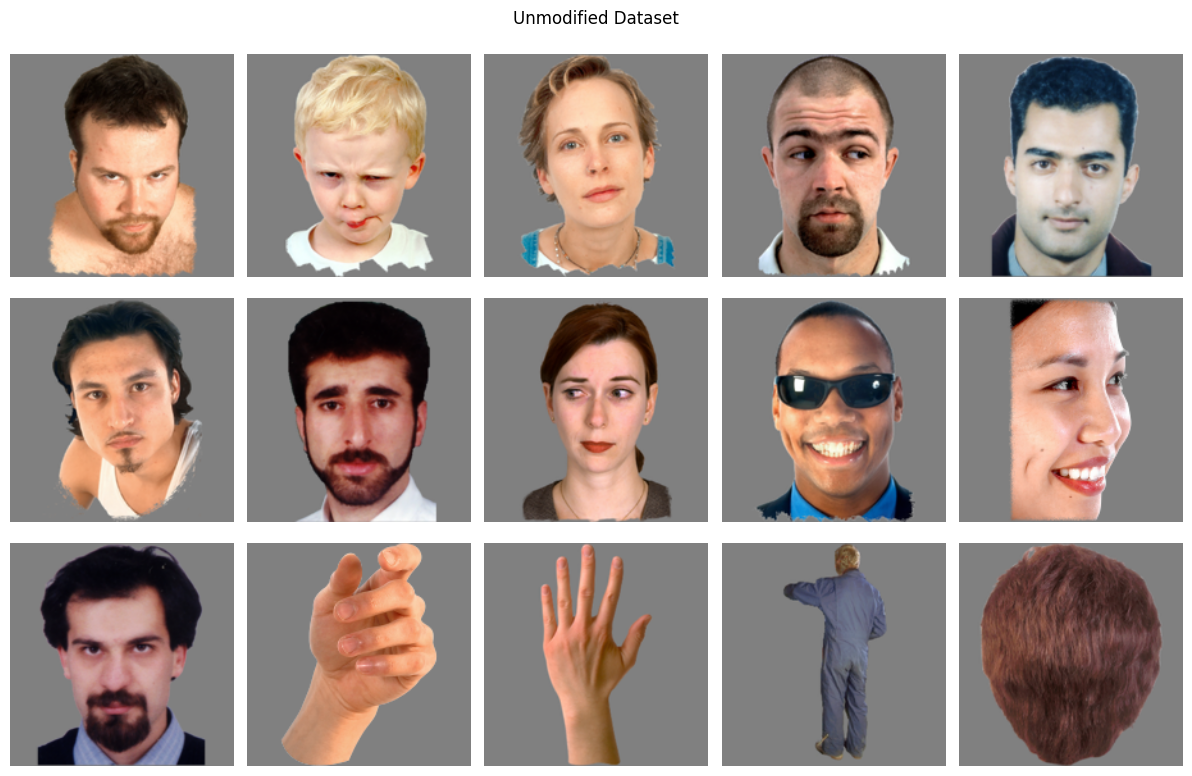

In [ ]:
visualize_augmentations(input_dataset, start_idx=0, title='Unmodified Dataset')

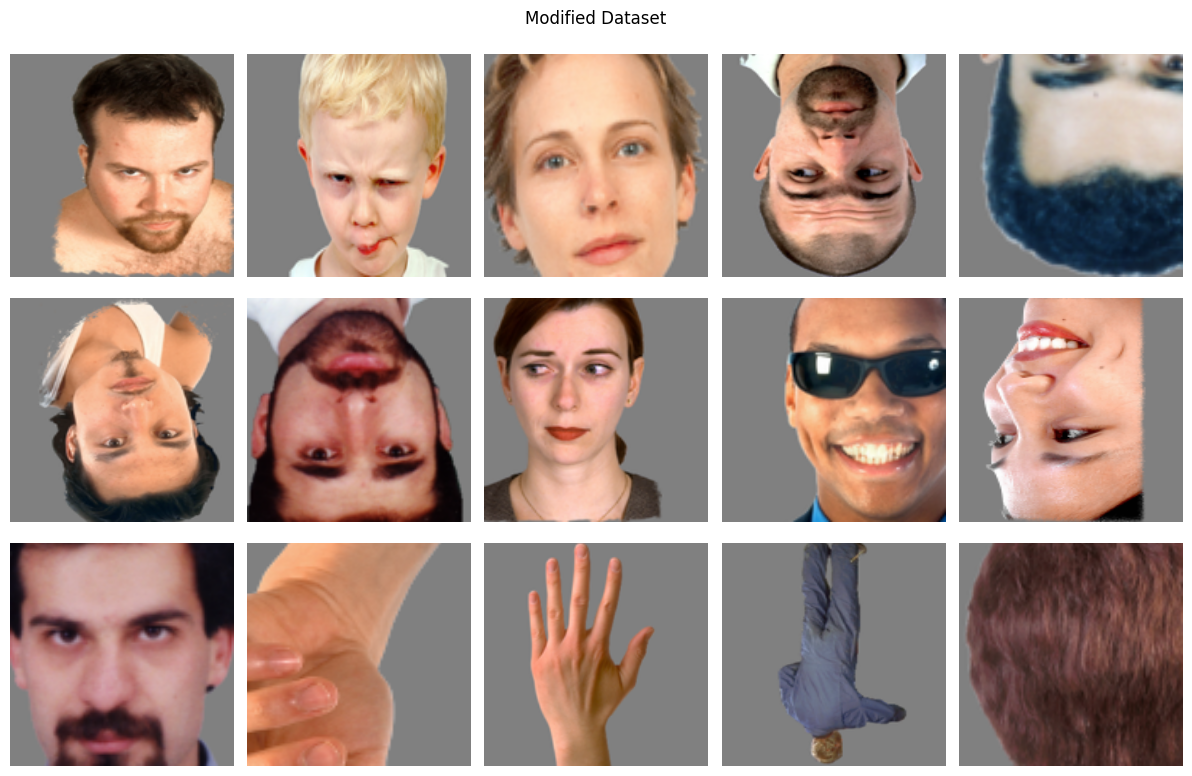

In [ ]:
visualize_augmentations(mod_dataset, start_idx=0, title='Modified Dataset')

# 2: Implement neural networks

## 2.1: Set up smaller dataset to test.

In [ ]:
abbr_images = input_images[0:5]

abbr_dataset = ImageDataset(abbr_images, basic_transforms)
abbr_loader = DataLoader(abbr_dataset, batch_size=BATCH_SIZE)

## 2.2: AlexNet

### 2.2.1: Load model in and set up forward hooks.

Looking at activations of five convolutional layers and three fully connected layers.

In [11]:
alexnetmodel = models.alexnet(weights='AlexNet_Weights.IMAGENET1K_V1')
alexnetmodel.to(device)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 138MB/s]


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

AlexNet has three components: `features`, `avgpool`, and `classifier`. The five convolutional layers (0, 3, 6, 8, 10) are in `features`. The three fully connected layers (1, 4, 6) are in `classifier`.

In [12]:
# Loop through the model's modules and register forward hooks for convolutional and fully connected layers
activations = {}

def get_activations_hook(name):
    def hook(module, input, output):
        activations[name] = output
    return hook

for name, module in alexnetmodel.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        # Register a forward hook for convolutional layers
        module.register_forward_hook(get_activations_hook(name))
    elif isinstance(module, torch.nn.Linear):
        # Register a forward hook for linear (fully connected) layers
        module.register_forward_hook(get_activations_hook(name))

### 2.2.2: Normal dataset: get activations and build RDMs

In [13]:
# ensure model won't learn
alexnetmodel.eval()

# send images through models
for batch in input_loader:
  inputs = batch.to(device)
  _ = alexnetmodel(inputs)

In [14]:
# Access the extracted activations for each layer
alexnet_layer_names = []
for name, activation in activations.items():
    print(f'Layer: {name}, Activation shape: {activation.shape}')
    alexnet_layer_names.append(name)

Layer: features.0, Activation shape: torch.Size([92, 64, 55, 55])
Layer: features.3, Activation shape: torch.Size([92, 192, 27, 27])
Layer: features.6, Activation shape: torch.Size([92, 384, 13, 13])
Layer: features.8, Activation shape: torch.Size([92, 256, 13, 13])
Layer: features.10, Activation shape: torch.Size([92, 256, 13, 13])
Layer: classifier.1, Activation shape: torch.Size([92, 4096])
Layer: classifier.4, Activation shape: torch.Size([92, 4096])
Layer: classifier.6, Activation shape: torch.Size([92, 1000])


Code as I have it only stores the latest batch activations.

In [15]:
alexnet_rdms = [] 

for layer in alexnet_layer_names:
  # convert activations from tensor to numpy
  activ = activations[layer].cpu().detach().numpy()

  # flatten activations
  flattened_activ = activ.reshape(*activ.shape[:1], -1)
  
  # construct rsm
  rsm = np.corrcoef(flattened_activ)

  # construct rdm
  rdm = digitize_rdm(1-rsm)

  alexnet_rdms.append(rdm)

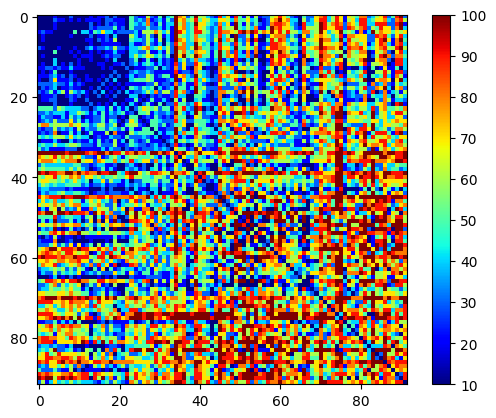

In [16]:
plt.imshow(alexnet_rdms[0], cmap='jet')
plt.colorbar()

### 2.2.3: Modified dataset: get activations and build RDMs

In [17]:
# ensure model won't learn
alexnetmodel.eval()

# send images through models
for batch in mod_loader:
  inputs = batch.to(device)
  _ = alexnetmodel(inputs)

In [18]:
alexnet_rdms_mod = [] 

for layer in alexnet_layer_names:
  # convert activations from tensor to numpy
  activ = activations[layer].cpu().detach().numpy()

  # flatten activations
  flattened_activ = activ.reshape(*activ.shape[:1], -1)
  
  # construct rsm
  rsm = np.corrcoef(flattened_activ)

  # construct rdm
  rdm = digitize_rdm(1-rsm)

  alexnet_rdms_mod.append(rdm)

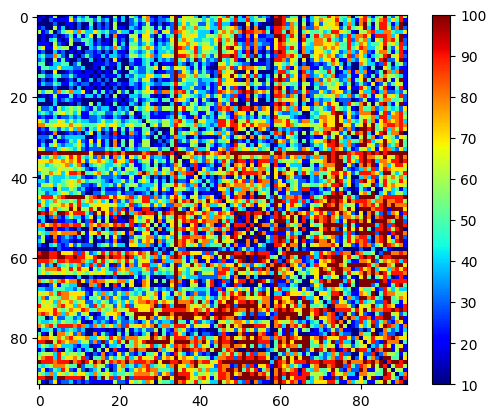

In [19]:
plt.imshow(alexnet_rdms_mod[0], cmap='jet')
plt.colorbar()

In [20]:
np.all(alexnet_rdms_mod[0] == alexnet_rdms[0])

False

In [21]:
np.save('alexnet_rdms.npy', np.asarray([alexnet_rdms,
                                        alexnet_rdms_mod]))

## 2.3: ResNet18

### 2.3.1: Load model in and set up forward hooks.

Only making hooks for convolutional layers (20)

In [22]:
rn18model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
rn18model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 21.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
# Loop through the model's modules and register forward hooks for convolutional and fully connected layers
activations = {}

def get_activations_hook(name):
    def hook(module, input, output):
        activations[name] = output
    return hook

for name, module in rn18model.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        # Register a forward hook for convolutional layers
        module.register_forward_hook(get_activations_hook(name))
    elif isinstance(module, torch.nn.Linear):
        # Register a forward hook for linear (fully connected) layers
        module.register_forward_hook(get_activations_hook(name))

### 2.3.2: Normal dataset: get activations and build RDMs

In [24]:
# ensure model won't learn
rn18model.eval()

# send images through models
for batch in input_loader:
  inputs = batch.to(device)
  _ = rn18model(inputs)

In [25]:
# Access the extracted activations for each layer
rn18_layer_names = []
for name, activation in activations.items():
    print(f'Layer: {name}, Activation shape: {activation.shape}')
    rn18_layer_names.append(name)

Layer: conv1, Activation shape: torch.Size([92, 64, 112, 112])
Layer: layer1.0.conv1, Activation shape: torch.Size([92, 64, 56, 56])
Layer: layer1.0.conv2, Activation shape: torch.Size([92, 64, 56, 56])
Layer: layer1.1.conv1, Activation shape: torch.Size([92, 64, 56, 56])
Layer: layer1.1.conv2, Activation shape: torch.Size([92, 64, 56, 56])
Layer: layer2.0.conv1, Activation shape: torch.Size([92, 128, 28, 28])
Layer: layer2.0.conv2, Activation shape: torch.Size([92, 128, 28, 28])
Layer: layer2.0.downsample.0, Activation shape: torch.Size([92, 128, 28, 28])
Layer: layer2.1.conv1, Activation shape: torch.Size([92, 128, 28, 28])
Layer: layer2.1.conv2, Activation shape: torch.Size([92, 128, 28, 28])
Layer: layer3.0.conv1, Activation shape: torch.Size([92, 256, 14, 14])
Layer: layer3.0.conv2, Activation shape: torch.Size([92, 256, 14, 14])
Layer: layer3.0.downsample.0, Activation shape: torch.Size([92, 256, 14, 14])
Layer: layer3.1.conv1, Activation shape: torch.Size([92, 256, 14, 14])
Laye

In [26]:
rn18_rdms = [] 

for layer in rn18_layer_names:
  # convert activations from tensor to numpy
  activ = activations[layer].cpu().detach().numpy()

  # flatten activations
  flattened_activ = activ.reshape(*activ.shape[:1], -1)
  
  # construct rsm
  rsm = np.corrcoef(flattened_activ)

  # construct rdm
  rdm = digitize_rdm(1-rsm)

  rn18_rdms.append(rdm)

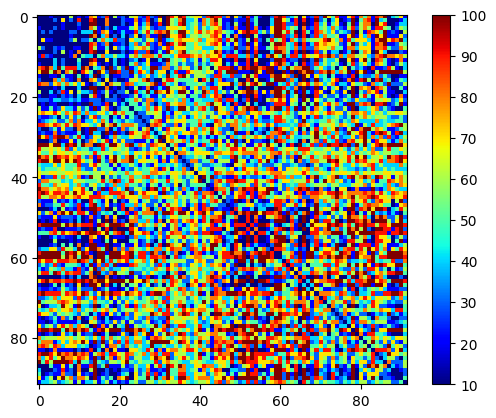

In [27]:
plt.imshow(rn18_rdms[0], cmap='jet')
plt.colorbar()

### 2.2.3: Modified dataset: get activations and build RDMs

In [28]:
# ensure model won't learn
rn18model.eval()

# send images through models
for batch in mod_loader:
  inputs = batch.to(device)
  _ = rn18model(inputs)

In [29]:
rn18_rdms_mod = [] 

for layer in rn18_layer_names:
  # convert activations from tensor to numpy
  activ = activations[layer].cpu().detach().numpy()

  # flatten activations
  flattened_activ = activ.reshape(*activ.shape[:1], -1)
  
  # construct rsm
  rsm = np.corrcoef(flattened_activ)

  # construct rdm
  rdm = digitize_rdm(1-rsm)

  rn18_rdms_mod.append(rdm)

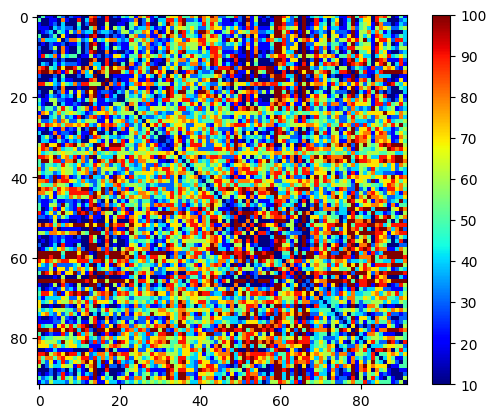

In [30]:
plt.imshow(rn18_rdms_mod[0], cmap='jet')
plt.colorbar()

In [32]:
np.all(rn18_rdms_mod[0] == rn18_rdms[0])

False

In [34]:
np.save('rn18_rdms.npy', np.asarray([rn18_rdms,
                                     rn18_rdms_mod]))